Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term
Enable just-in-time compilation with XLA.


Compiling model...
Building feed-forward neural network...
'build' took 0.084252 s



C:\Users\kozak\anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\legacy_tf_layers\core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
C:\Users\kozak\anaconda3\envs\tensorflow-gpu\lib\site-packages\keras\engine\base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'compile' took 1.624373 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric   
0         [9.17e-01, 9.34e-01]    [9.17e-01, 9.34e-01]    [9.82e-01]    
1000      [1.28e-04, 4.56e-02]    [1.32e-04, 4.56e-02]    [2.68e-01]    
2000      [9.04e-06, 4.53e-02]    [9.36e-06, 4.53e-02]    [2.68e-01]    
3000      [4.72e-05, 4.44e-02]    [4.79e-05, 4.44e-02]    [2.66e-01]    
4000      [5.42e-03, 2.20e-02]    [5.76e-03, 2.20e-02]    [2.06e-01]    
5000      [1.12e-02, 8.48e-03]    [1.19e-02, 8.48e-03]    [1.53e-01]    
6000      [7.02e-03, 5.90e-03]    [7.51e-03, 5.90e-03]    [1.36e-01]    
7000      [3.14e-03, 3.09e-03]    [3.48e-03, 3.09e-03]    [1.07e-01]    
8000      [2.05e-03, 1.72e-03]    [2.35e-03, 1.72e-03]    [8.60e-02]    
9000      [1.59e-03, 1.10e-03]    [1.84e-03, 1.10e-03]    [7.35e-02]    
10000     [1.32e-03, 7.50e-04]    [1.53e-03, 7.50e-04]    [6.46e-02]    
11000     [1.14e-03, 5.25e-04]    [1.32e-03, 5.25e-0

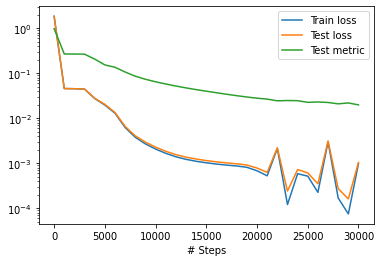

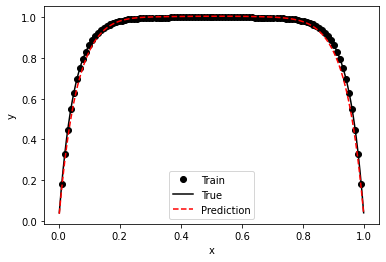

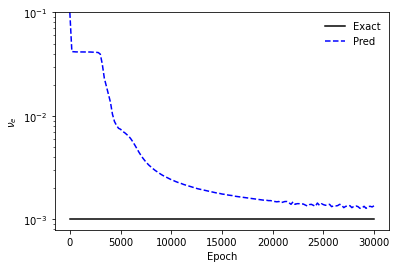

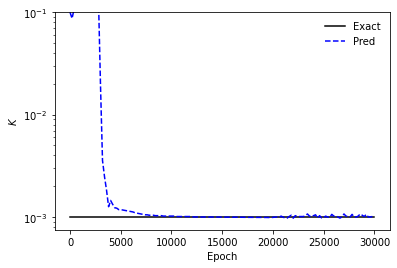

In [1]:
import re

import deepxde as dde
import matplotlib.pyplot as plt
import numpy as np

g = 1
v = 1e-3
e = 0.4
H = 1

v_e = dde.Variable(0.1)
K = dde.Variable(0.1)


def sol(x):
    r = (v * e / (1e-3 * 1e-3)) ** (0.5)
    return g * 1e-3 / v * (1 - np.cosh(r * (x - H / 2)) / np.cosh(r * H / 2))


def gen_traindata(num):
    xvals = np.linspace(1 / (num + 1), 1, num, endpoint=False)
    yvals = sol(xvals)
    return np.reshape(xvals, (-1, 1)), np.reshape(yvals, (-1, 1))


def pde(x, y):
    du_xx = dde.grad.hessian(y, x)
    return -v_e / e * du_xx + v * y / K - g


def output_transform(x, y):
    return x * (1 - x) * y


geom = dde.geometry.Interval(0, 1)
ob_x, ob_u = gen_traindata(5)
observe_u = dde.icbc.PointSetBC(ob_x, ob_u, component=0)

data = dde.data.PDE(
    geom,
    pde,
    solution=sol,
    bcs=[observe_u],
    num_domain=100,
    num_boundary=0,
    train_distribution="uniform",
    num_test=500,
)

net = dde.nn.FNN([1] + [20] * 3 + [1], "tanh", "Glorot uniform")
net.apply_output_transform(output_transform)
model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"], external_trainable_variables=[v_e, K])
variable = dde.callbacks.VariableValue([v_e, K], period=200, filename="variables1.dat")

losshistory, train_state = model.train(iterations=30000, callbacks=[variable])
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

lines = open("variables1.dat", "r").readlines()
vkinfer = np.array(
    [
        np.fromstring(
            min(re.findall(re.escape("[") + "(.*?)" + re.escape("]"), line), key=len),
            sep=",",
        )
        for line in lines
    ]
)

l, c = vkinfer.shape
v_etrue = 1e-3
ktrue = 1e-3

plt.figure()
plt.plot(
    range(0, 200 * l, 200),
    np.ones(vkinfer[:, 0].shape) * v_etrue,
    color="black",
    label="Exact",
)
plt.plot(range(0, 200 * l, 200), vkinfer[:, 0], "b--", label="Pred")
plt.xlabel("Epoch")
plt.yscale("log")
plt.ylim(top=1e-1)
plt.legend(frameon=False)
plt.ylabel(r"$\nu_e$")

plt.figure()
plt.plot(
    range(0, 200 * l, 200),
    np.ones(vkinfer[:, 1].shape) * ktrue,
    color="black",
    label="Exact",
)
plt.plot(range(0, 200 * l, 200), vkinfer[:, 1], "b--", label="Pred")
plt.xlabel("Epoch")
plt.yscale("log")
plt.ylim(ymax=1e-1)
plt.legend(frameon=False)
plt.ylabel(r"$K$")

plt.show()

151